buffer

In [ ]:
import numpy as np
import os
import sys
sys.path.append("/home/wang_c/Gitlab/blender2-renderer")

import util
import bpy
import glob
from PIL import Image

class DepthInterface():
    def __init__(self, resolution=128, background_color=(1,1,1)):
        self.resolution = resolution

        # Deselect all. All new object added to the scene will automatically selected.
        self.blender_renderer = bpy.context.scene.render
        self.blender_renderer.use_antialiasing = False
        self.blender_renderer.resolution_x = resolution
        self.blender_renderer.resolution_y = resolution
        self.blender_renderer.resolution_percentage = 100
        self.blender_renderer.image_settings.file_format = 'PNG'  # set output format to .png

        self.blender_renderer.alpha_mode = 'SKY'

        world = bpy.context.scene.world
        world.horizon_color = background_color
        world.light_settings.use_environment_light = True
        world.light_settings.environment_color = 'SKY_COLOR'
        world.light_settings.environment_energy = 1.

        # Set up the camera
        self.camera = bpy.context.scene.camera
        self.camera.data.sensor_height = self.camera.data.sensor_width # Square sensor
        util.set_camera_focal_length_in_world_units(self.camera.data, 525./512*resolution) # Set focal length to a common value (kinect)

        bpy.ops.object.select_all(action='DESELECT')

    def import_mesh(self, fpath, scale=1., object_world_matrix=None):
        ext = os.path.splitext(fpath)[-1]
        if ext == '.obj':
            bpy.ops.import_scene.obj(filepath=str(fpath), split_mode='OFF')
        elif ext == '.ply':
            bpy.ops.import_mesh.ply(filepath=str(fpath))

        obj = bpy.context.selected_objects[0]
        obj.name = "model_normalized"
        util.dump(bpy.context.selected_objects)

        if object_world_matrix is not None:
            obj.matrix_world = object_world_matrix

        bpy.ops.object.origin_set(type='ORIGIN_GEOMETRY', center='BOUNDS')
        obj.location = (0., 0., 0.) # center the bounding box!

        if scale != 1.:
            bpy.ops.transform.resize(value=(scale, scale, scale))

        # Disable transparency & specularities
        M = bpy.data.materials
        for i in range(len(M)):
            M[i].use_transparency = False
            M[i].specular_intensity = 0.0

        # Disable texture interpolation
        T = bpy.data.textures
        for i in range(len(T)):
            try:
                T[i].use_interpolation = False
                T[i].use_mipmap = False
                T[i].use_filter_size_min = True
                T[i].filter_type = "BOX"
            except:
                continue
        
    def render(self, output_dir, blender_cam2world_matrices):
        depth_dir = os.path.join(output_dir, "depth")
        util.cond_mkdir(depth_dir)

        # save the paths to all the rendered masks for post processing 
        rendered_depth_paths = []

        for i in range(len(blender_cam2world_matrices)):
            self.camera.matrix_world = blender_cam2world_matrices[i]

            if os.path.exists(os.path.join(depth_dir, '%06d.png' % i)):
                continue

            self.set_up_depth(depth_dir)

            # Render the mask
            bpy.ops.render.render(write_still=False)  # write_still=False will not save the RGB image.

            # rename the mask image since it's given a default name by Blender
            file_list = glob.glob(os.path.join(depth_dir, 'Image*.png'))
            if file_list:
                stupid_default_name = file_list[0]
                new_name = os.path.join(depth_dir, f'{i:06d}.png')
                os.system(f"mv {stupid_default_name} {new_name}")
                rendered_depth_paths.append(new_name)
            
        # Remember which meshes were just imported
        meshes_to_remove = []
        for ob in bpy.context.selected_objects:
            meshes_to_remove.append(ob.data)

        bpy.ops.object.delete()

        # Remove the meshes from memory too
        for mesh in meshes_to_remove:
            bpy.data.meshes.remove(mesh)

        return rendered_depth_paths

    def set_up_depth(self, depth_dir):
        bpy.context.scene.render.layers.active.use_pass_z = True
        bpy.context.scene.use_nodes = True
        tree = bpy.context.scene.node_tree
        links = tree.links
        for node in tree.nodes:
            tree.nodes.remove(node)
        render_layer_node = tree.nodes.new(type='CompositorNodeRLayers')
        normalize_node = tree.nodes.new(type='CompositorNodeNormalize')
        try:
            links.new(render_layer_node.outputs['Z'], normalize_node.inputs[0])
        except KeyError:
            links.new(render_layer_node.outputs['Depth'], normalize_node.inputs[0])
        depth_output_node = tree.nodes.new(type='CompositorNodeOutputFile')
        depth_output_node.base_path = depth_dir
        # Set the output to PNG format with 16-bit depth
        depth_output_node.format.file_format = 'PNG'
        depth_output_node.format.color_depth = '16'
        links.new(normalize_node.outputs[0], depth_output_node.inputs[0])

           
           
pose_path = "/nodes/bosch/fastwork/schmidt/SRN_Dataset/cars_train/1a1dcd236a1e6133860800e6696b8284/pose/000000.txt"
temp_save_path = "/home/wang_c/Downloads/buffer"
obj_path = "/globalwork/datasets/ShapeNetCore.v2/02958343/1a1dcd236a1e6133860800e6696b8284/models/model_normalized.obj"

os.system(f"rm -rf {temp_save_path}")
os.system(f"mkdir {temp_save_path}")
                
renderer = DepthInterface()
obj_location = np.zeros((1,3))
cam_pose = util.read_pose(pose_path)
blender_poses = [util.cv_cam2world_to_bcam2world(cam_pose)]
obj_pose = None#np.eye(4)
#renderer.import_mesh(obj_path, scale=1., object_world_matrix=obj_pose)
renderer.render(temp_save_path, blender_poses)

In [1]:

def render_mask(output_dir):
    # Set object index for the object
    bpy.data.objects['model_normalized'].pass_index = 1
    # Enable Object Index pass
    bpy.context.scene.render.layers['RenderLayer'].use_pass_object_index = True
    # Node setup for compositing
    bpy.context.scene.use_nodes = True
    tree = bpy.context.scene.node_tree
    links = tree.links
    # Clear default nodes
    for node in tree.nodes:
        tree.nodes.remove(node)
    # Add Render Layer node
    render_layer_node = tree.nodes.new('CompositorNodeRLayers')
    # Add ID Mask node
    id_mask_node = tree.nodes.new('CompositorNodeIDMask')
    id_mask_node.index = 1
    links.new(render_layer_node.outputs['IndexOB'], id_mask_node.inputs[0])
    # Add File Output Node
    file_output_node = tree.nodes.new('CompositorNodeOutputFile')
    file_output_node.base_path = output_dir
    links.new(id_mask_node.outputs[0], file_output_node.inputs[0])
    # Render the scene
    bpy.ops.render.render(write_still=True)

In [2]:
import sys
sys.path.append('/home/wang_c/Gitlab/blender2-renderer')

import os
import util
import bpy
import numpy as np 

obj_dir = '//home/wang_c/Downloads/shapenet_part/1a1dcd236a1e6133860800e6696b8284/models/model_normalized.obj'
pose_dir = '/home/wang_c/Downloads/SRN_part/1a1dcd236a1e6133860800e6696b8284/pose/000000.txt'
intrinsic_dir = ''
output_dir = '/home/wang_c/Downloads/buffer'

os.system(f'rm -rf {output_dir}')
os.system(f'mkdir {output_dir}')

import blender_interface
renderer = blender_interface.BlenderInterface(resolution=128)

obj_location = np.zeros((1,3))

# read camera pose from txt file 
cam_pose = util.read_pose(pose_dir)

### test ###
#  To set the obj matrix to identity, we should also change the cam_pose. 
#  (rotating it by -90 deg along x-axis)
"""
cam_pose = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0],
    [0, -1, 0, 0],
    [0, 0, 0, 1]]) @ cam_pose

"""

blender_poses = [util.cv_cam2world_to_bcam2world(cam_pose)]

obj_pose = None #np.eye(4)

renderer.import_mesh(obj_dir, scale=1., object_world_matrix=obj_pose)
renderer.render(output_dir, blender_poses, write_cam_params=True)

# =====================================




ModuleNotFoundError: No module named 'bpy'

# Mask

In [3]:
import imageio.v3 as iio 
import matplotlib.pyplot as plt
import numpy as np 

# in fact, rgba
img_rgb = iio.imread('/home/wang_c/Downloads/buffer0/1a1dcd236a1e6133860800e6696b8284/rgb/000035.png')
img_mask = iio.imread('/home/wang_c/Downloads/buffer0/1a1dcd236a1e6133860800e6696b8284/mask/000021.png')

print("RGB shape:", img_rgb.shape)
print("Mask shape:", img_mask.shape)
print("4 channels of Mask are same:", [np.allclose(img_mask[:, :, 0], img_mask[:, :, 1]) for i in range(3)])

print("Set(Mask pixels)=", set(img_mask.ravel().tolist()))
 
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_rgb)
axes[0].axis('off')
axes[0].set_title('RGB')
pos = axes[1].imshow(img_mask[:, :, 0], cmap='gray')
axes[1].axis('off')
axes[1].set_title('Mask')
fig.colorbar(pos, ax=axes[1])
plt.show()


RGB shape: (128, 128, 4)
Mask shape: (128, 1)


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
# in fact, rgba
img_depth = iio.imread('/home/wang_c/Downloads/buffer0/1a1dcd236a1e6133860800e6696b8284/depth/000035.png')


print("RGB shape:", img_rgb.shape)
print("Depth shape:", img_depth.shape)
print("4 channels of Depth are same:", [np.allclose(img_depth[:, :, 0], img_depth[:, :, 1]) for i in range(3)])

print("Set(Depth pixels)=", set(img_depth.ravel().tolist()))
 
fig, axes = plt.subplots(2, 2, figsize=(10, 5))
axes[0,0].imshow(img_rgb)
axes[0,0].axis('off')
axes[0,0].set_title('RGB')
pos = axes[1,0].imshow(img_depth[:, :, 0])
axes[1,0].axis('off')
axes[1,0].set_title('Depth')
pos = axes[0,1].imshow(img_depth[:, :, 1])
axes[0,1].axis('off')
axes[0,1].set_title('Depth2')
pos = axes[1,1].imshow(img_depth[:, :, 3])
axes[1,1].axis('off')
axes[1,1].set_title('Depth3')
fig.colorbar(pos, ax=axes[1])
plt.show()

In [ ]:
import os 
import numpy as np 

img_dir = '/home/wang_c/Downloads/SRN_part'
output_dir = '/home/wang_c/Downloads/buffer2'
obj_dir = '/home/wang_c/Downloads/shapenet_part'


def get_subdirectories(base_dir, directory=True):
    subdirectories = [os.path.join(base_dir, d) for d in os.listdir(base_dir) if (not directory) or os.path.isdir(os.path.join(base_dir, d))]
    return subdirectories

def get_obj_path(obj):
    obj_name = obj.split('/')[-1]
    return os.path.join(obj_dir, obj_name, "models/model_normalized.obj")
    
os.system(f"rm -rf {output_dir}")
os.mkdir(output_dir)     


objects = sorted(get_subdirectories(img_dir))
objects

In [ ]:

def save_obj(render, pose_path, obj_path):
    parent_dir = os.path.join(output_dir, pose_path.split('/')[-3])
    mask_path = os.path.join(parent_dir, 'mask')
    if not os.path.exists(mask_path):
        os.makedirs(mask_path)
    temp_save_path = os.path.join(mask_path, "buffer")
    original_mask_path = os.path.join(temp_save_path, "mask/000000.png")
    png_name = (pose_path.split('/')[-1]).split('.')[0]
    new_mask_path = os.path.join(mask_path, f"{png_name}.png")
    print(png_name)



In [ ]:
renderer = None 
for obj in objects: 
    pose_path = os.path.join(obj, 'pose')
    poses = sorted(get_subdirectories(pose_path, directory=False))
    obj_path = get_obj_path(obj)
    for pose_path in poses:
        save_obj(renderer, pose_path, obj_path)

### Post-processing mask: Convert 4-channel/[0, 255] to 1-channel/[0, 1]

In [ ]:
from PIL import Image
import numpy as np

mask_path = "/home/wang_c/Downloads/buffer0/1a1dcd236a1e6133860800e6696b8284/mask/000021.png"

with Image.open(mask_path) as img:
    # Your code here
    image_np = np.array(img)
    gray_image_np = np.mean(image_np[..., :3], axis=-1)
    scaled_image_np = gray_image_np / 255.0

    # Convert back to PIL Image and save
    scaled_image = Image.fromarray((scaled_image_np * 255).astype(np.uint8), 'L')
    scaled_image.save("1_channel_image.png")



### Find the ID of car and chair objects in shapenet.v2

In [4]:
import os 

def get_subdirectories(base_dir, directory=True):
    if os.path.isdir(base_dir):
        return [os.path.join(base_dir, d) for d in os.listdir(base_dir) if (not directory) or os.path.isdir(os.path.join(base_dir, d))]
    else:
        return []
    
base_dir = "/globalwork/datasets/ShapeNetCore.v2"

targets = [
    "80ac9cc0d4c9dde3b7a7bc444c2d756b", 
    "8141677722f680076a2345809e2bb169", 
    "81655a19f4ce2daa8fd988235de2147e", 
    "817bb8c69e4ac23ec81ddeca50aa3117", 
    "81c52d54f9719736ce27281f3b76d1f5", 
]

objs = get_subdirectories(base_dir)
for i, obj in enumerate(objs):
    instances = get_subdirectories(obj)
    for j, instance in enumerate(instances):
        # print("\r", end=" ")
        # print(f"obj: {i}/{len(objs)} | instance {j}/{len(instances)}", end=" ")
        label = instance.split('/')[-1]
        for target in targets:
            if label == target:
                print(" ")
                print(instance)
         
     

 
/globalwork/datasets/ShapeNetCore.v2/02958343/80ac9cc0d4c9dde3b7a7bc444c2d756b
 
/globalwork/datasets/ShapeNetCore.v2/02958343/817bb8c69e4ac23ec81ddeca50aa3117
 
/globalwork/datasets/ShapeNetCore.v2/02958343/8141677722f680076a2345809e2bb169
 
/globalwork/datasets/ShapeNetCore.v2/02958343/81c52d54f9719736ce27281f3b76d1f5
 
/globalwork/datasets/ShapeNetCore.v2/02958343/81655a19f4ce2daa8fd988235de2147e


In [5]:
import os

for i in range(10):
    if os.path.exists("stop"):
        print("Stop file found. Exiting.")
        break
    print('hi')
    


Stop file found. Exiting.


RGB shape: (128, 128, 4)
Depth shape: (128, 128)


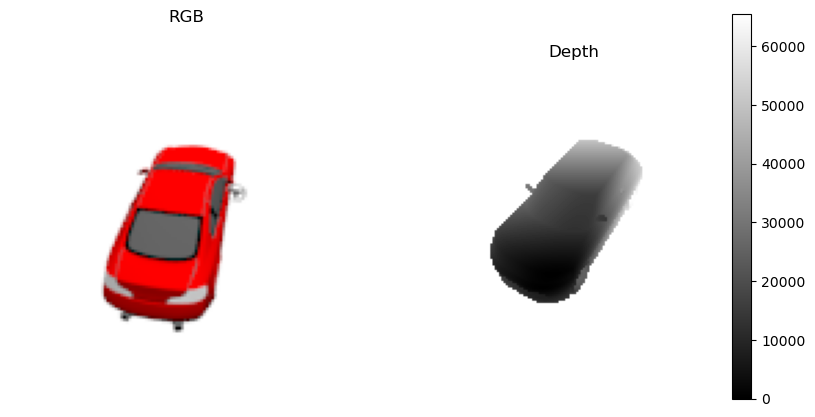

In [5]:
import imageio.v3 as iio 
import matplotlib.pyplot as plt
import numpy as np 
import cv2 

depth = '/nodes/astra/fastwork/wang_c/SRN_depth/cars_train/1a1dcd236a1e6133860800e6696b8284/depth/000001.png'

img_rgb = iio.imread('/nodes/bosch/fastwork/schmidt/SRN_Dataset/cars_train/100715345ee54d7ae38b52b4ee9d36a3/rgb/000000.png')
img_depth = cv2.imread(depth, cv2.IMREAD_UNCHANGED)

print("RGB shape:", img_rgb.shape)
print("Depth shape:", img_depth.shape)

 
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_rgb)
axes[0].axis('off')
axes[0].set_title('RGB')
pos = axes[1].imshow(img_depth, cmap='gray')
axes[1].axis('off')
axes[1].set_title('Depth')
fig.colorbar(pos, ax=axes[1])
plt.show()


In [13]:
import cv2

img = cv2.imread(depth, cv2.IMREAD_UNCHANGED)
print(min(img.ravel()), max(img.ravel()))



0 65535


0.0 0.0
{0.0}


TypeError: Invalid shape (262144,) for image data

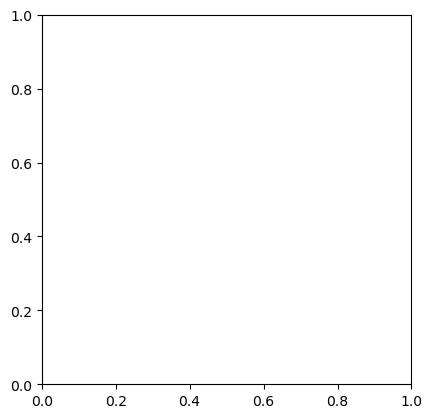

## Depth info in Blender

- Camera near and far plane can be set in Camera-Properties-Data-Start and -end Clipping. The unit is consistent with blender environment. 
- The depth of backgournd (far plane) will be set as 100000000000.0 (10^11).
- Blender uses "vertical depth."
- The (unnormalized) depth value has the same scale as the distance value in Blender environment.
- Found out how normalize layer in Blender works.

min: 1.0 max: 100000000000.0
number of different values: 1973
channel_0==channel_1: True
channel_1==channel_2: True
channel_2==channel_3: False
min: 5.9821243 max: 100000000000.0


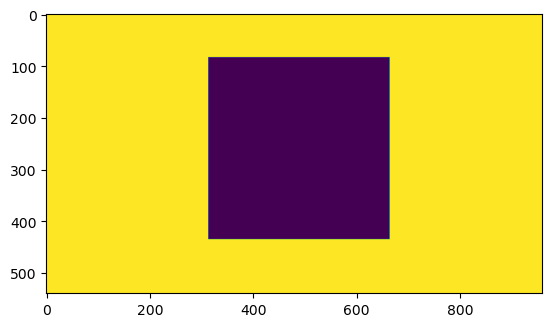

In [42]:
import matplotlib.pyplot as plt 
import numpy as np 

with np.load('/home/wang_c/Downloads/dmap.npz') as data:
    dmap = data["dmap"]
    
print("min:", dmap.min(), "max:", dmap.max())
print("number of different values:", len(set(dmap.ravel().tolist())))
print("channel_0==channel_1:", np.allclose(dmap[:, :, 0], dmap[:, :, 1]))
print("channel_1==channel_2:", np.allclose(dmap[:, :, 1], dmap[:, :, 2]))
print("channel_2==channel_3:", np.allclose(dmap[:, :, 2], dmap[:, :, 3]))

print('='*50)
dmap = dmap[:, :, 0] # take channel 0
print("min:", dmap.min(), "max:", dmap.max())

plt.imshow(dmap)
plt.show()


min: 0.0 max: 1.0
number of different values: 1106
channel_0==channel_1: True
channel_1==channel_2: True
channel_2==channel_3: False
min: 0.0 max: 1.0


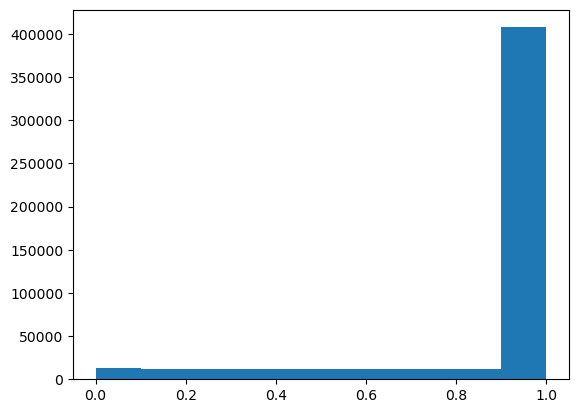

In [43]:
import matplotlib.pyplot as plt 
import numpy as np 

with np.load('/home/wang_c/Downloads/dmap_normalized.npz') as data:
    dmap = data["dmap"]
    
print("min:", dmap.min(), "max:", dmap.max())
print("number of different values:", len(set(dmap.ravel().tolist())))
print("channel_0==channel_1:", np.allclose(dmap[:, :, 0], dmap[:, :, 1]))
print("channel_1==channel_2:", np.allclose(dmap[:, :, 1], dmap[:, :, 2]))
print("channel_2==channel_3:", np.allclose(dmap[:, :, 2], dmap[:, :, 3]))

print('='*50)
dmap = dmap[:, :, 0] # take channel 0
print("min:", dmap.min(), "max:", dmap.max())

plt.imshow(dmap)
plt.show()

plt.hist(dmap.ravel())
plt.show()

min: 0.0 max: 1.0
number of different values: 1971
channel_0==channel_1: True
channel_1==channel_2: True
channel_2==channel_3: False
min: 0.0 max: 1.0


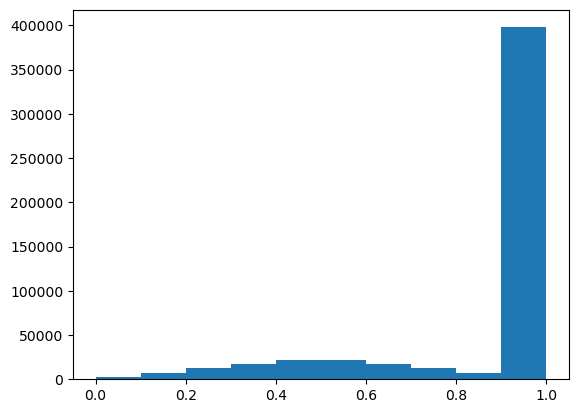

In [44]:
import matplotlib.pyplot as plt 
import numpy as np 

with np.load('/home/wang_c/Downloads/dmap_normalized_2.npz') as data:
    dmap = data["dmap"]
    
print("min:", dmap.min(), "max:", dmap.max())
print("number of different values:", len(set(dmap.ravel().tolist())))
print("channel_0==channel_1:", np.allclose(dmap[:, :, 0], dmap[:, :, 1]))
print("channel_1==channel_2:", np.allclose(dmap[:, :, 1], dmap[:, :, 2]))
print("channel_2==channel_3:", np.allclose(dmap[:, :, 2], dmap[:, :, 3]))

print('='*50)
dmap = dmap[:, :, 0] # take channel 0
print("min:", dmap.min(), "max:", dmap.max())

plt.imshow(dmap)
plt.show()

plt.hist(dmap.ravel())
plt.show()

min: 5.9821243 max: 100000000000.0


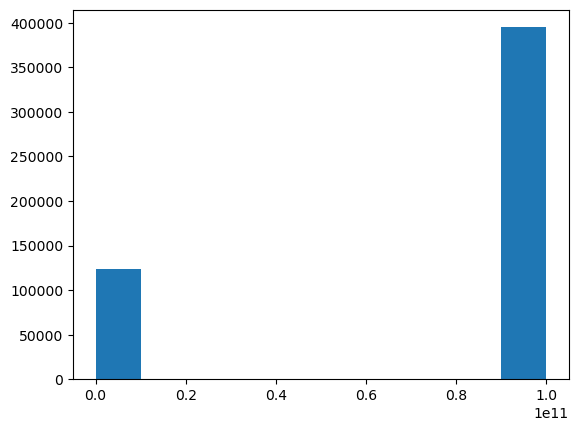

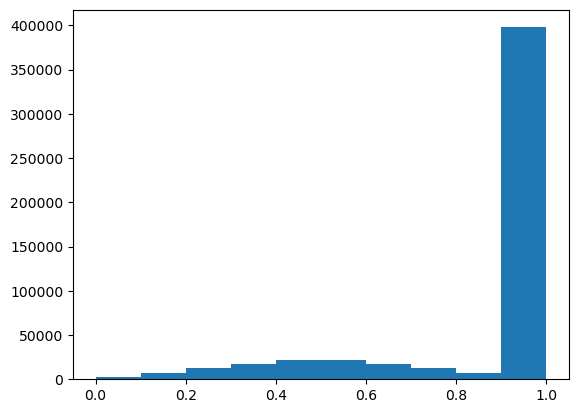

normalization successful: True


In [53]:
"""try to reproduce the normalization"""

import matplotlib.pyplot as plt 
import numpy as np 

with np.load('/home/wang_c/Downloads/dmap.npz') as data:
    dmap = data["dmap"]

dmap = dmap[:, :, 0] # take channel 0
print("min:", dmap.min(), "max:", dmap.max())

plt.hist(dmap.ravel())
plt.show()

def normalize(dmap):
    dmap_norm = dmap.copy()
    threshold = 0.5e11
    dmap_max = dmap[dmap < threshold].max() # find the max. below the threshold 
    dmap_norm[dmap > threshold] = dmap_max # set digits above the threshold to be the max. below the threshold 
    dmap_norm = (dmap_norm - dmap_norm.min()) / (dmap_norm.max() - dmap_norm.min()) # normalize to 0~1
    return dmap_norm 

dmap_norm = normalize(dmap)

plt.hist(dmap_norm.ravel())
plt.show()

with np.load('/home/wang_c/Downloads/dmap_normalized_2.npz') as data:
    dmap_normalized_2 = data["dmap"][: ,: ,0]
    
print("normalization successful:", np.allclose(dmap_norm, dmap_normalized_2))


min: 1.0 max: 100000000000.0
number of different values: 199646
channel_0==channel_1: True
channel_1==channel_2: True
channel_2==channel_3: False
min: 4.576883 max: 100000000000.0


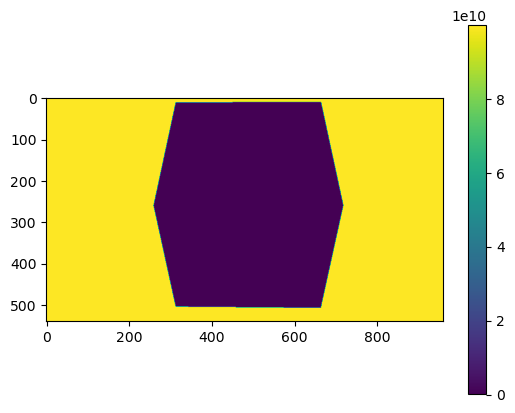

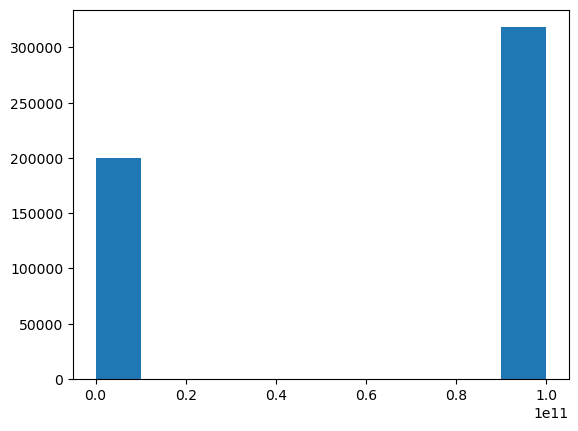

In [59]:
import matplotlib.pyplot as plt 
import numpy as np 

with np.load('/home/wang_c/Downloads/dmap_farplane.npz') as data:
    dmap = data["dmap"]
    
def normalize(dmap):
    dmap_norm = dmap.copy()
    threshold = 0.5e11
    dmap_max = dmap[dmap < threshold].max() # find the max. below the threshold 
    dmap_norm[dmap > threshold] = dmap_max # set digits above the threshold to be the max. below the threshold 
    # dmap_norm = (dmap_norm - dmap_norm.min()) / (dmap_norm.max() - dmap_norm.min()) # normalize to 0~1
    return dmap_norm 
#dmap = normalize(dmap)
    
print("min:", dmap.min(), "max:", dmap.max())
print("number of different values:", len(set(dmap.ravel().tolist())))
print("channel_0==channel_1:", np.allclose(dmap[:, :, 0], dmap[:, :, 1]))
print("channel_1==channel_2:", np.allclose(dmap[:, :, 1], dmap[:, :, 2]))
print("channel_2==channel_3:", np.allclose(dmap[:, :, 2], dmap[:, :, 3]))

print('='*50)
dmap = dmap[:, :, 0] # take channel 0
print("min:", dmap.min(), "max:", dmap.max())

plt.imshow(dmap)
plt.colorbar()
plt.show()

plt.hist(dmap.ravel())
plt.show()

float32
min: 0.9640204 max: 100000000000.0
(128, 128)


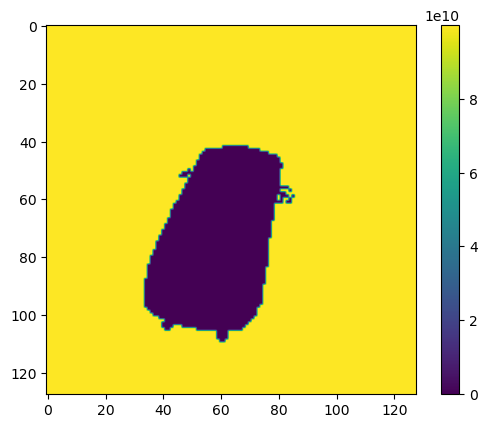

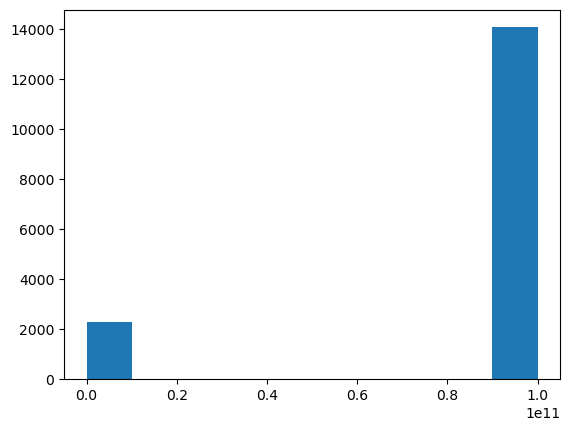

In [106]:
import matplotlib.pyplot as plt 
import numpy as np 

with np.load('/home/wang_c/Downloads/buffer/cars_train/100715345ee54d7ae38b52b4ee9d36a3/depth/000000.npz') as data:
    dmap = data["depth_map"]
    print(dmap.dtype)
    
def normalize(dmap):
    dmap_norm = dmap.copy()
    threshold = 0.5e11
    dmap_max = dmap[dmap < threshold].max() # find the max. below the threshold 
    dmap_norm[dmap > threshold] = dmap_max # set digits above the threshold to be the max. below the threshold 
    # dmap_norm = (dmap_norm - dmap_norm.min()) / (dmap_norm.max() - dmap_norm.min()) # normalize to 0~1
    return dmap_norm 
#dmap = normalize(dmap)
    


print('='*50)
print("min:", dmap.min(), "max:", dmap.max())
print(dmap.shape)

plt.imshow(dmap)
plt.colorbar()
plt.show()

plt.hist(dmap.ravel())
plt.show()

In [ ]:
import OpenEXR
import Imath
import numpy as np
import matplotlib.pyplot as plt

def read_exr(file_path):
    # Open the input file
    file = OpenEXR.InputFile(file_path)

    # Compute the size
    dw = file.header()['dataWindow']
    size = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)

    # Read the three color channels as 32-bit floats
    FLOAT = Imath.PixelType(Imath.PixelType.FLOAT)
    (R, G, B) = [np.frombuffer(file.channel(c, FLOAT), dtype=np.float32) for c in ("R", "G", "B")]
    R = np.reshape(R, (size[1], size[0]))
    G = np.reshape(G, (size[1], size[0]))
    B = np.reshape(B, (size[1], size[0]))

    # Create an array to hold all the channels
    img_array = np.zeros((size[1], size[0], 3), dtype=np.float32)

    img_array[..., 0] = R
    img_array[..., 1] = G
    img_array[..., 2] = B

    return img_array

# Path to the .exr file
file_path = '/home/wang_c/Downloads/buffer/cars_train/100715345ee54d7ae38b52b4ee9d36a3/depth/Image0001.exr'

# Read and show the image
img = read_exr(file_path)

# Note: Your EXR might be HDR, so adjust display range as needed
plt.imshow(img, cmap='gray')
plt.colorbar()
plt.show()


(128, 128, 3)
0.9640204 100000000000.0 float32


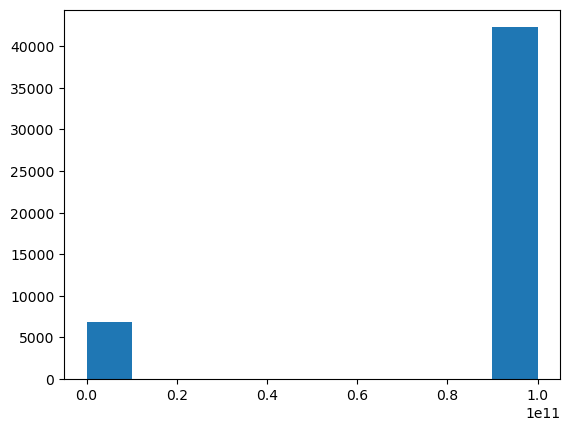

In [82]:
import os 
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"

import cv2 
import numpy as np 
import matplotlib.pyplot as plt 

file_path = '/home/wang_c/Downloads/buffer/cars_train/100715345ee54d7ae38b52b4ee9d36a3/depth/000000.exr'

img = cv2.imread(file_path,  cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)  

print(img.shape)
print(img.min(), img.max(), img.dtype)
plt.hist(img.ravel())
plt.show()

(128, 128)
5719 65535 uint16


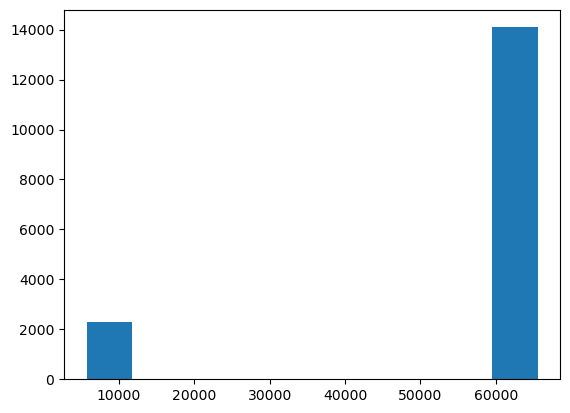

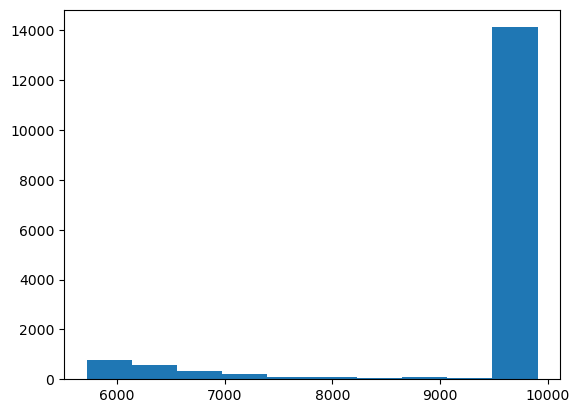

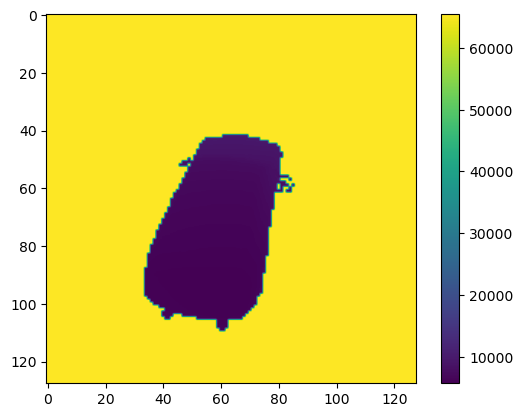

In [130]:
file_path = '/nodes/astra/fastwork/wang_c/SRN_depth/cars_train/100715345ee54d7ae38b52b4ee9d36a3/depth/000000.png'
img_normalized = cv2.imread(file_path,  cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)  

def bunch_of_checks(img, high_threshold):
    print(img.shape)
    print(img.min(), img.max(), img.dtype)
    plt.hist(img.ravel())
    plt.show()
    img_clipped = img.copy()
    img_clipped[img > high_threshold] = img_clipped[img < high_threshold].max()
    plt.hist(img_clipped.ravel())
    plt.show()

    plt.imshow(img)
    plt.colorbar()
    plt.show()
    
bunch_of_checks(img_normalized, high_threshold = 20000)

In [37]:
def get_original_depth(img_normalized, min_d = 0.1, max_d = 10):
    img = img_normalized / (2**16 - 1)
    depth = min_d + (max_d - min_d) * img
    return depth 


In [133]:
"""
Precision: 

near plane: d = 0.1
far plane: d = 10

[0.1, 10] => [0, 1]
divided by 9.9

16-bit png: 65536 values 
error = 1/65536 * 9.9 = 0.00015106201171875 = 1.51 * 10^-4
"""

'\nPrecision: \n\nnear plane: d = 0.1\nfar plane: d = 10\n\n'

### find bizzare Objects in SRN dataset

In [ ]:
import os 
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import numpy as np
import cv2 
import glob
from pathlib import Path

# return True if the image is one-channel
def isOneChannel(img):
    return True if len(img.shape) == 2 else False

# return True if the image contains an object (not only background)
def isNotEmpty(img):
    values_count = len(set(img.ravel().tolist()))
    return True if values_count > 20 else False 
    # the threshold should be 1, but let's set it higher so it can detect some weird objects in the dataset

def isNormailized(img, d_min = 0.1):
    img_max = img.max()
    img_min = img.min()
    return True if img_min >= 0 and img_max <= 65535 else False 

def print_path(path):
    print(path.split("/")[-4], path.split("/")[-3], path.split("/")[-1])

# loop through all the .png files under start_dir 
def find_png_files(start_dir):
    # The '**' pattern means "this directory and all subdirectories"
    # The 'recursive=True' makes sure the pattern '**' is applied recursively
    for img_path in tqdm.tqdm(glob.glob(f"{start_dir}/**/*.png", recursive=True)):
        img = cv2.imread(img_path,  cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH) 
        checks = [isOneChannel, isNotEmpty, isNormailized]
        for check in checks:
            if not check(img):
                print_path(img_path)
                print(f"| {check.__name__}: False")


# check if the number of rendered depth images matches its original dataset (e.g. SRN car_train)
def check_obj_num(start_dir, obj_num, pose_num):
    p = Path(start_dir)
    # check if number of objects are correct 
    detected_obj_num = len([sub_dir for sub_dir in p.iterdir() if sub_dir.is_dir()])
    if detected_obj_num != obj_num:
        raise ValueError(f"Expected {obj_num} objects, but found {detected_obj_num} objects.")
    # check of number of images (poses) are correct for an object 
    for sub_dir in p.iterdir():
        depth_dir = sub_dir / "depth"
        detected_pose_num = len(list(depth_dir.glob('*.png')))
        if detected_pose_num != pose_num:
            raise ValueError(f"Expected {pose_num} png files, but found {detected_pose_num} files. \n {depth_dir}")

start_dir = "/nodes/astra/fastwork/wang_c/SRN_depth/cars_test"
check_obj_num(start_dir, obj_num = 704, pose_num = 251)
find_png_files(start_dir)